In [1]:
from layout import Layout, tiled_color_map, default_index2tile

## Definition
The (logical) product is defined as $A \otimes B := (A, \tilde A \circ B)$.

In terms of the pseudo code:
```python
size = self.size() * other.cosize()
compl = self.complement(size)
compo = compl.composite(other)
return Layout.from_concate(self, compo)
```

It is best to illustrate the idea of a logical product using a 2D by-mode example as follows.

## 2D By-Mode Product

For 2D layout $A = (A_{s_1}, A_{s_2}):(A_{d_1}, A_{d_2})$ and $B = (B_{s_1}, B_{s_2}):(B_{d_1}, B_{d_2})$,
the product $A \otimes B$ will generate $B_{s_1} \times B_{s_2}$ tiles where the first tile is $A$.
And the resulting stride along the m-axis is $(A_{s_1} \times B_{d_1})$, and $(A_{s_2} \times B_{d_2})$ along the n-axis.

((2, 3), (5, 4)):((5, 40), (1, 50))

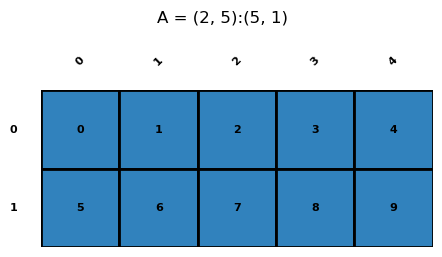

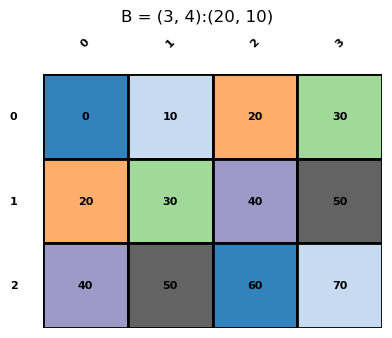

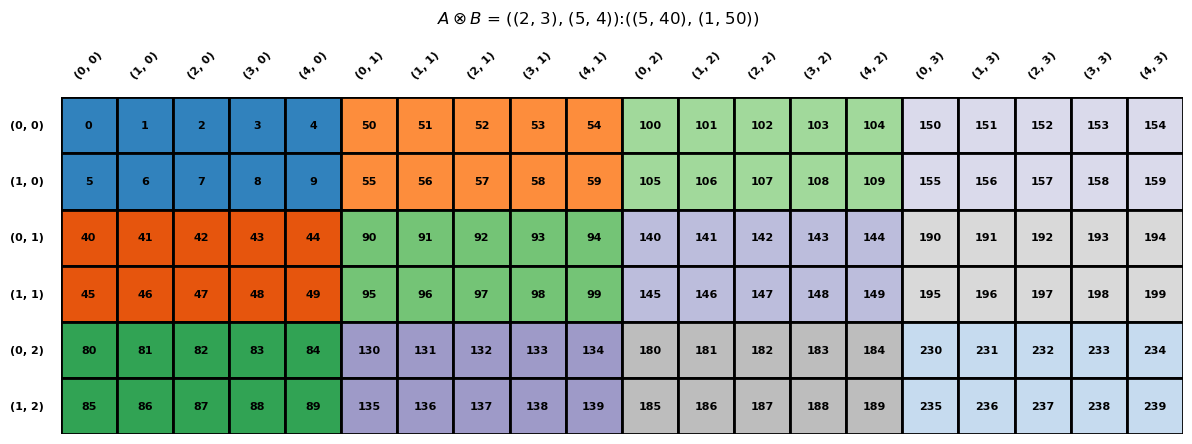

In [2]:
A = Layout.from_string('(2,5):(5,1)').visualize('A', color_cycle=10)
B = Layout.from_string('(3,4):(20,10)').visualize('B', color_cycle=3)
A.logical_product(B, by_mode=True).visualize('$A \\otimes B$', color_cycle=10)

To understand how the product operation achieves the desired effect, let us break it down into steps and mode by mode.

For the 1st mode, we expect the result $C_1$ to contain $A_1$ as its first "tile". Specifically,
* $\operatorname{size}(C_1) = \operatorname{size}(A_1) \times \operatorname{size}(B_1) = 2 \times 3 = 6$
* $\operatorname{stride-across-tiles}(C_1) = \operatorname{size}(A_1) \times \operatorname{stride}(B_1) = 2 \times 20 = 40$

How does the product operation achieve these? All we know is the formula $C_1 := (A_1, \tilde A_1 \circ B_1)$.

First, to avoid the "pointer" $B_1$ points anywhere out-of-bound, we allocate $\tilde{A_1} =\operatorname{complement}(A_1, x)$ with a cortarget $x$ large enough to cover $\operatorname{cosize}(B_1)=41$.
According to the complement formula [2], the resulting $\operatorname{size}(\tilde{A_1}) = (d_1 / 1) \cdot (d_2 / (s_1 d_1)) ... (x/ (s_{k-1} d_{k-1})) \ge x / \operatorname{size}(A_1)$.
Hence it is safe to set $\operatorname{size}(\tilde{A_1}) \ge x / \operatorname{size}(A_1) = \operatorname{cosize}(B_1) = 41$ which implies we need to set $x = \operatorname{size}(A_1) \times \operatorname{cosize}(B_1)$.

Second, to meet the expected product layout requirements, the intermediate steps
* use $B_1$ as the pointer which implies that $\tilde A_1 \circ B_1$ is the same size of $B_1$. The later concatenation operation $(A_1, \tilde A_1 \circ B_1)$ will ensure $C_1$ to have a shape equal to $\operatorname{size}(A_1) \times \operatorname{size}(B_1)$;
* for "stride across tiles", assume a unit stride of $B_1$ (i.e., $20$) will be pointing to the $y$-th column of $\tilde A_1$. Assuming $A_1=s:d$, the stride (alone n-axis) of $\tilde A_1$ is $s \times d = 2 \times 5 = 10$ due to the formula of complement [2], and $y = 20 / \operatorname{height}(\tilde A_1) = 20 / d$. Therefore it will point at index $(s \times d) \times (20 / d) = s \times 20$ which is exactly $\operatorname{size}(A_1) \times \operatorname{stride}(B_1)$.

size =  2 * 41 = 82
complement: sorted (stride, shape) = [(5, 2)]
complement: + 5/1:1
complement: + 82/10:10
composite: + min(5/20, 3):1*20
composite: + 3:10*4



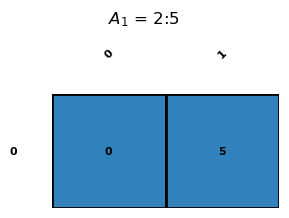

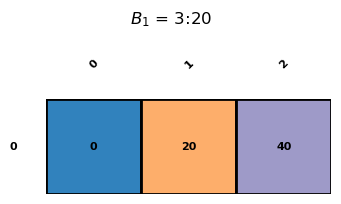

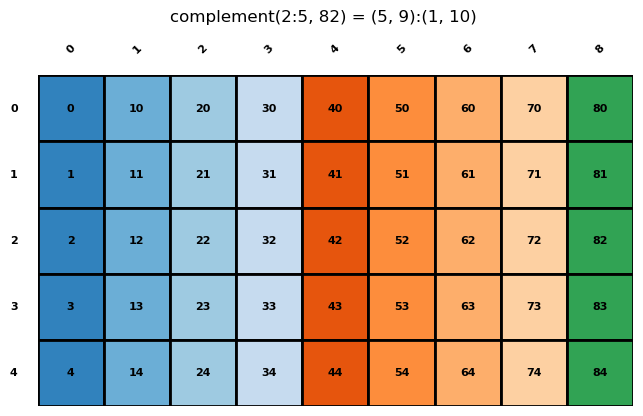

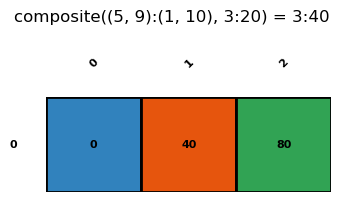

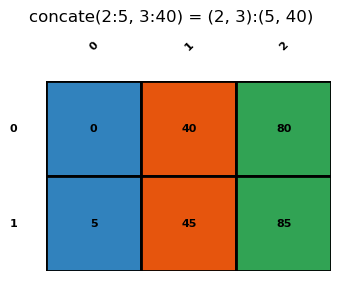

In [3]:
A1 = Layout.from_string('2:5').visualize('$A_1$', color_cycle=10)
B1 = Layout.from_string('3:20').visualize('$B_1$', color_cycle=3)
print('size = ', A1.size(), '*', B1.cosize(), '=', size:=A1.size() * B1.cosize())
_ = A1.logical_product(B1, visualize_steps=True, verbose=True, color_cycle=10)

Similarly, for the 2nd mode:

size =  5 * 31 = 155
complement: sorted (stride, shape) = [(1, 5)]
complement: + 1/1:1
complement: + 155/5:5
composite: + 4:5*10



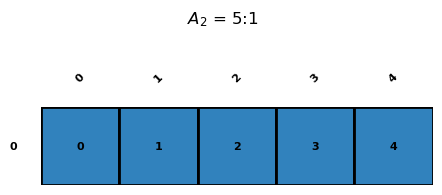

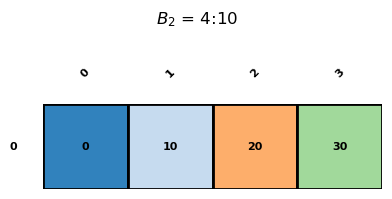

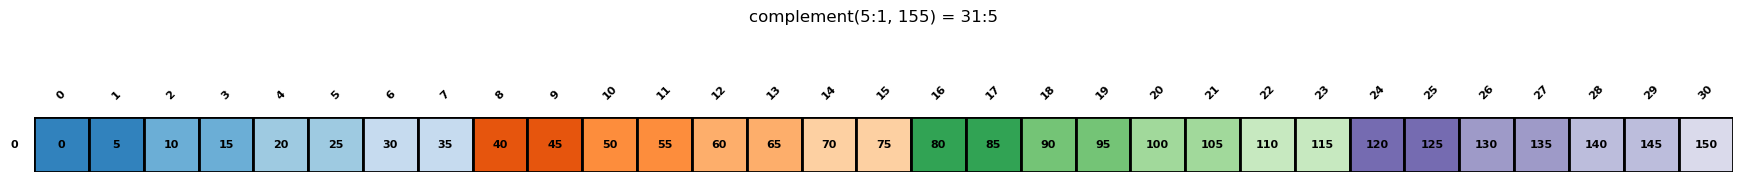

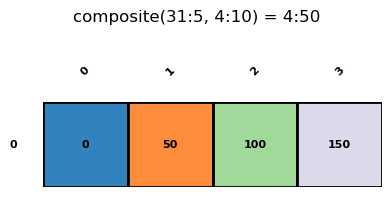

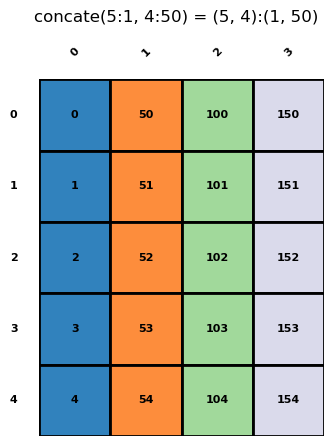

In [4]:
A2 = Layout.from_string('5:1').visualize('$A_2$', color_cycle=10)
B2 = Layout.from_string('4:10').visualize('$B_2$', color_cycle=3)
print('size = ', A2.size(), '*', B2.cosize(), '=', size:=A2.size() * B2.cosize())
_ = A2.logical_product(B2, visualize_steps=True, verbose=True, color_cycle=10)

## General Product

By-mode product is only simple when you want to construct tiles with uniform cross-tile strides along each dimension.
When this is not the case, you may need more compicated $A_i$ and $B_i$ with $> 1$ ranks at each mode $i$.

Now we turn to some examples taken from CuTe docs [1].
Although they are no more by-mode product operations, they study more general and more complicated cases where $A$ and $B$ are no longer rank-1.
In this case, it is hard to predict the outcome tile layouts right away unless you do careful step-by-step calculations.

complement: sorted (stride, shape) = [(1, 2), (4, 2)]
complement: + 1/1:1
complement: + 4/2:2
complement: + 24/8:8
composite: + min(2/1, 6):2*1
composite: + 3:8*1



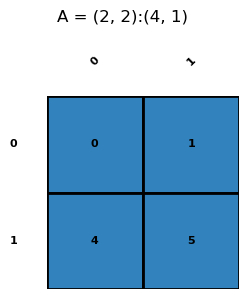

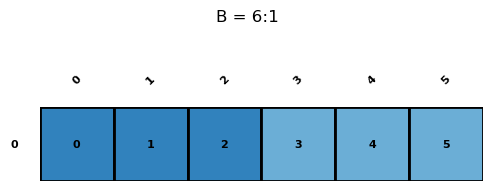

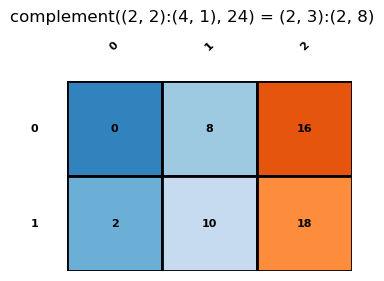

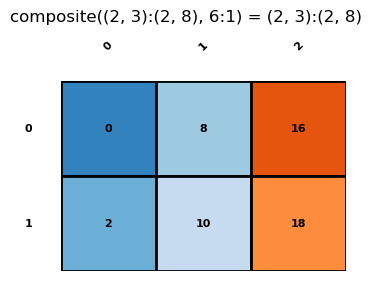

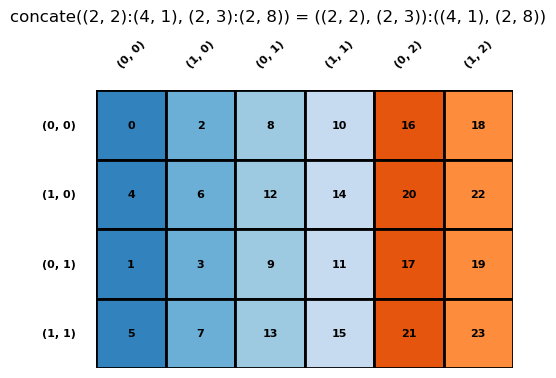

In [5]:
A = Layout.from_string('(2,2):(4,1)')
B = Layout.from_string('6:1')
C = A.logical_product(B)
color_map = tiled_color_map(C.shape, default_index2tile(C))
A.visualize('A', color_map=color_map)
B.visualize('B', color_cycle=3)
_ = A.logical_product(B, visualize_steps=True, verbose=True, color_map=color_map)

Another example:

complement: sorted (stride, shape) = [(1, 2), (4, 2)]
complement: + 1/1:1
complement: + 4/2:2
complement: + 32/8:8
composite: + min(2/2, 4):2*2
composite: + 4:8*1

composite: + min(2/1, 2):2*1
composite: + 1:8*1



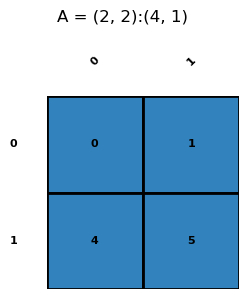

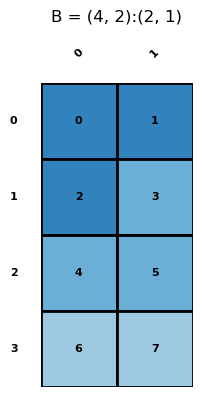

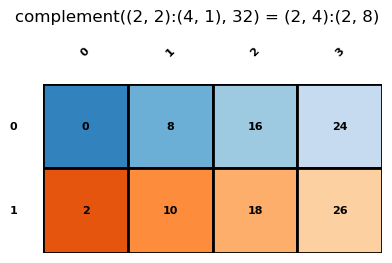

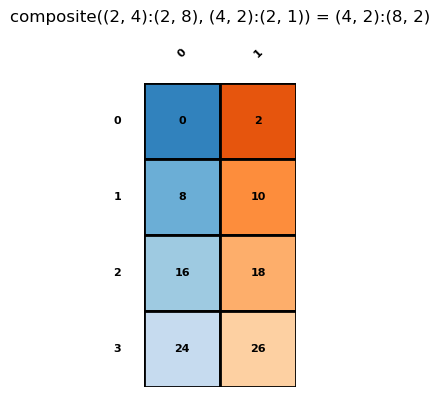

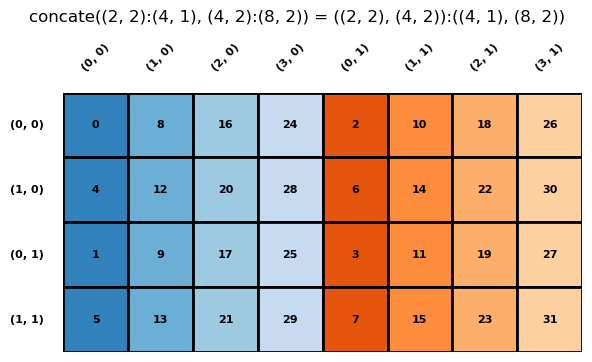

In [6]:
A = Layout.from_string('(2,2):(4,1)')
B = Layout.from_string('(4,2):(2,1)')
C = A.logical_product(B)
color_map = tiled_color_map(C.shape, default_index2tile(C))
A.visualize('A', color_map=color_map)
B.visualize('B', color_cycle=3)
_ = A.logical_product(B, visualize_steps=True, verbose=True, color_map=color_map)

## Blocked Product

Even CuTe docs [1] acknowledge that the calculation of general product is counterintuitive.
Therefore, it is often easier to use a *blocked_product* which applies a regular product once and then "unzip" the result to form span-mode 2D tiles.
In this way, there would be no need to design by-mode product for each mode.

In blocked product, One just needs to choose the shape of $B$ to scale up the "template tile" $A$,
and think of $\tilde{A}$ as *feasible* options for the offsets of the rest of tiles you want to construct.
Then, one should carefully design the stride of $B$ to select those options in $\tilde{A}$. The composite result $\tilde A \circ B$ will intuitively represent the final results in a zoomed-out view where each cell is mapped to an offset of a final tile.

For example:

complement: sorted (stride, shape) = [(2, 2), (12, 5)]
complement: + 2/1:1
complement: + 12/4:4
complement: + 710/60:60
composite: + min(2/2, 6):1*2
composite: + min(3/1, 6):4*1
composite: + 2:60*1

composite: + min(2/20, 4):1*20
composite: + min(3/10, 4):4*10
composite: + 4:60*4



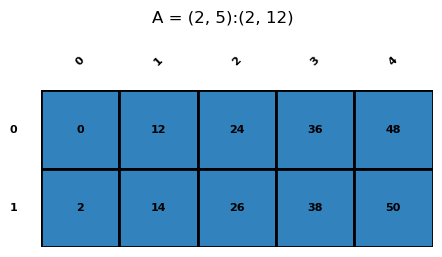

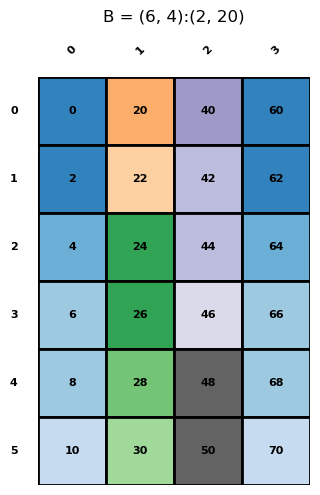

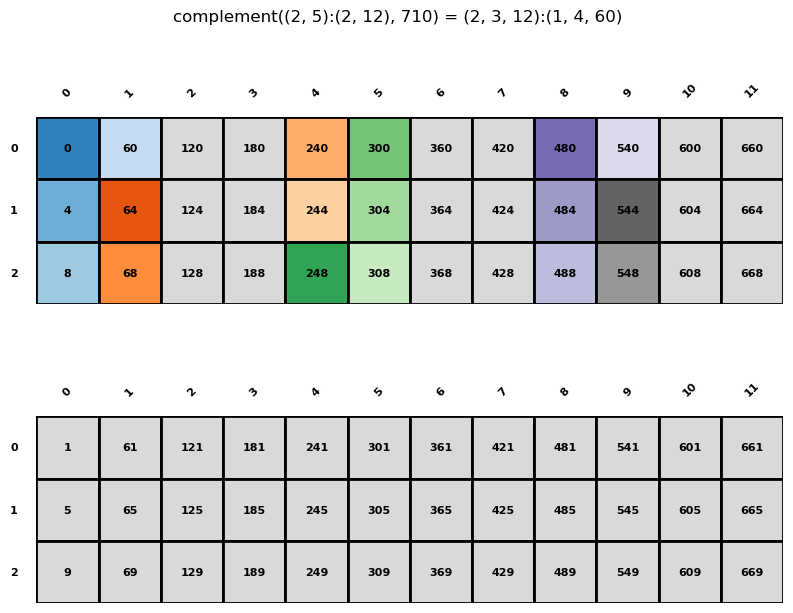

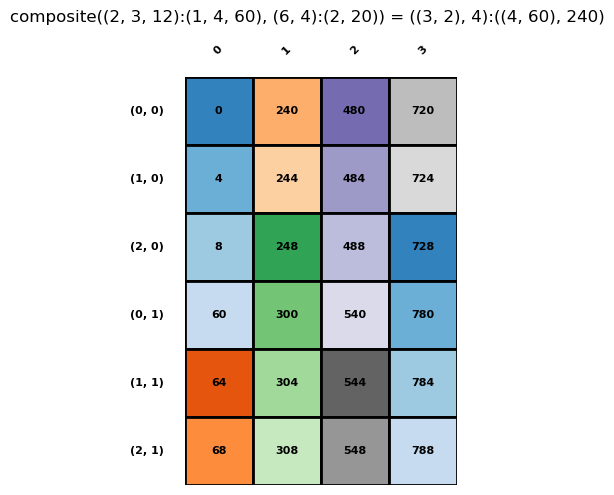

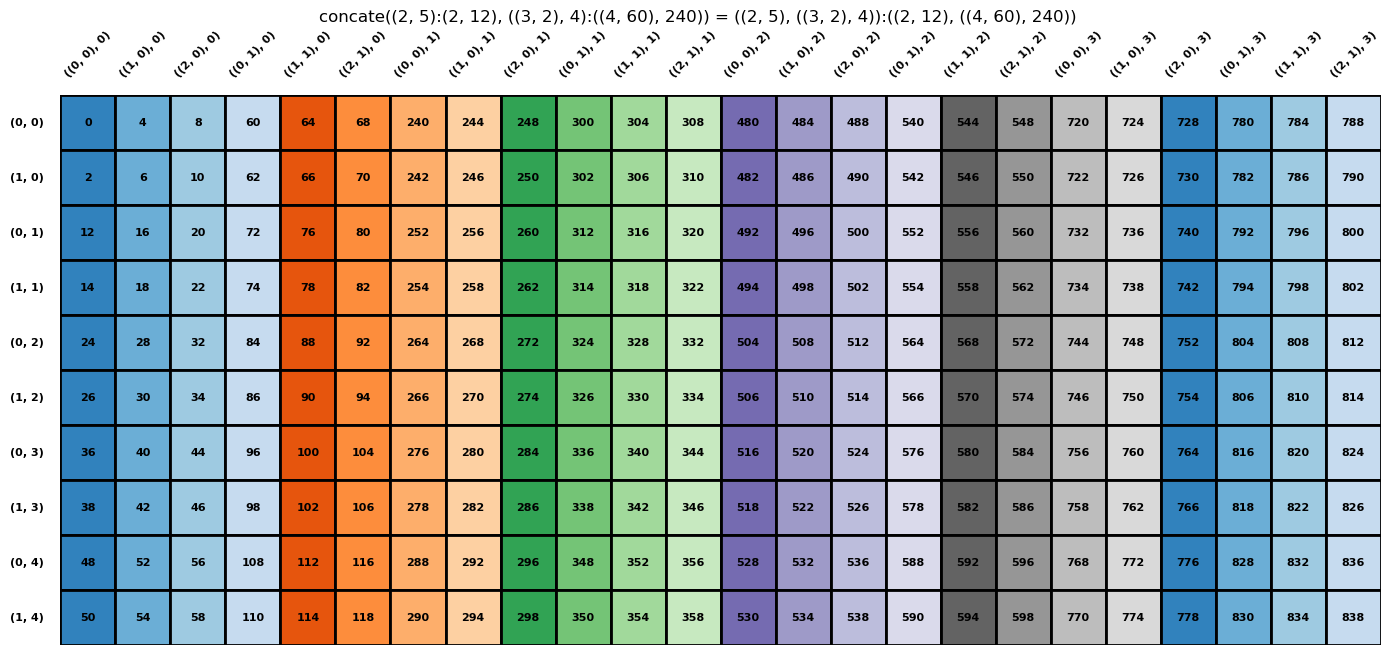

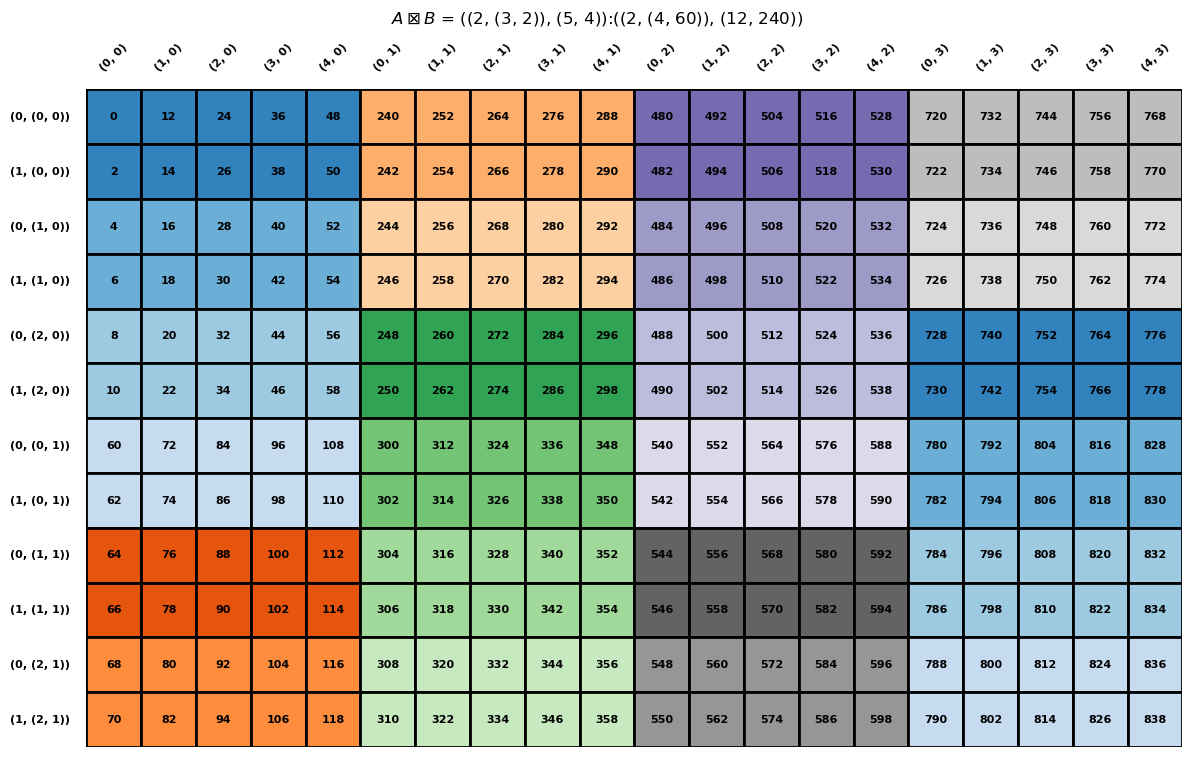

In [7]:
A = Layout.from_string('(2,5):(2,12)')
B = Layout.from_string('(6,4):(2,20)')
C = A.logical_product(B)
color_map = tiled_color_map(C.shape, default_index2tile(C))
A.visualize('A', color_map=color_map)
B.visualize('B', color_cycle=3)
_ = A.logical_product(B, visualize_steps=True, verbose=True, color_map=color_map)
_ = A.blocked_product(B).visualize(r'$A \boxtimes B$', color_map=color_map)

## Reference
[1] https://github.com/NVIDIA/cutlass/blob/acb45938e9cb3e4db8c1d75155b63d31791e0e5d/media/docs/cpp/cute/02_layout_algebra.md

[2] [Complement Formula](layout_basics.ipynb#Complement)